# 📈 03 – Advanced Visualizations & Rolling Analysis

## Overview

This notebook extends the factor modeling analysis with **time-varying** perspectives and **advanced visualizations**:

1. **Rolling Window Analysis**: Examine how model fit (R²) changes over time
2. **Dynamic Factor Sensitivity**: Track evolving relationships between EM and macro factors  
3. **Interactive Visualizations**: Generate comprehensive charts for all EM indices
4. **Reusable Functions**: Modular code for reproducible analysis

### Key Features:
- **Rolling R² Analysis**: 60-day rolling window regression models
- **Time-Series Visualization**: Dynamic model performance tracking
- **Batch Processing**: Automated chart generation for all EM indices
- **Export Functionality**: Save all visualizations to output folder

### Use Cases:
- **Risk Management**: Identify periods of high/low factor sensitivity
- **Portfolio Analysis**: Understand when diversification benefits change
- **Market Timing**: Spot regime changes in EM-macro relationships

## 📦 Import Required Libraries

Loading libraries for advanced analysis and visualization:

In [1]:
# Core data manipulation
import pandas as pd
import numpy as np
import os

# Machine learning components  
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting style for professional appearance
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10, 6)

## 📁 Data Loading & Preparation

Load the dataset and prepare variables for rolling analysis.

In [2]:
# =============================================================================
# STEP 1: DATA LOADING 
# =============================================================================
df = pd.read_csv('../data/combined_em_macro_data.csv', parse_dates=['date'], index_col='date')

print(f"📊 Dataset loaded: {df.shape[0]} rows × {df.shape[1]} columns")
print(f"📅 Date range: {df.index.min()} to {df.index.max()}")
# =============================================================================
# STEP 2: ENGINEERING TERM SPREAD
# =============================================================================
shift_value = df['Term_Spread'].min()
if shift_value < 0:
    print("Shift value is negative, adding a buffer to avoid negative values")
    shift_value = df['Term_Spread'].min() - 0.1 # add a buffer to avoid negative values
    print(f"Shift value: {shift_value}")
else:
    print("Shift value is positive, no buffer needed")

df['Term_Spread_Engineered'] = df['Term_Spread'] - shift_value

# Display the results
print(f"🔧 Term_Spread Engineering:")
print(f"   • Original min: {df['Term_Spread'].min():.4f}")
print(f"   • Original max: {df['Term_Spread'].max():.4f}")
print(f"   • Shift applied: +{shift_value:.4f}")
print(f"   • Engineered min: {df['Term_Spread_Engineered'].min():.4f}")
print(f"   • Engineered max: {df['Term_Spread_Engineered'].max():.4f}")
df.drop(columns=['Term_Spread'], inplace=True)
df.rename(columns={'Term_Spread_Engineered': 'Term_Spread'}, inplace=True)

# =============================================================================
# STEP 3: LOG RETURNS
# =============================================================================
log_returns = np.log(df / df.shift(1)).dropna()

print(f"📈 Log returns calculated: {log_returns.shape[0]} observations")
print(f"🧹 Data cleaning: {df.shape[0] - log_returns.shape[0]} rows dropped (missing/infinite values)")

# Display basic statistics
print(f"\n📋 Log Returns Summary:")
log_returns.describe().round(4)

📊 Dataset loaded: 3653 rows × 17 columns
📅 Date range: 2015-08-07 00:00:00 to 2025-08-06 00:00:00
Shift value is negative, adding a buffer to avoid negative values
Shift value: -1.1812857159999997
🔧 Term_Spread Engineering:
   • Original min: -1.0813
   • Original max: 1.5802
   • Shift applied: +-1.1813
   • Engineered min: 0.1000
   • Engineered max: 2.7614
📈 Log returns calculated: 3652 observations
🧹 Data cleaning: 1 rows dropped (missing/infinite values)

📋 Log Returns Summary:


,Brazil,India,China,SouthAfrica,Mexico,Indonesia,Taiwan,Korea,US,USD_Index,Oil_Brent,US_10Y_Yield,US_2Y_Yield,VIX,Copper,BAA_spread,Term_Spread
count,3652.0000,3652.0000,3652.0000,3652.0000,3652.0000,3652.0000,3652.0000,3652.0000,3652.0000,3652.0000,3652.0000,3652.0000,3652.0000,3652.0000,3652.0000,3652.0000,3652.0000
mean,0.0000,0.0003,0.0001,0.0001,0.0000,0.0000,0.0003,0.0002,0.0003,0.0000,0.0001,0.0002,0.0005,0.0001,0.0002,-0.0002,-0.0001
std,0.0172,0.0086,0.0126,0.0105,0.0126,0.0106,0.0099,0.0096,0.0097,0.0036,0.0209,0.0256,0.0341,0.0674,0.0109,0.0114,0.0424
min,-0.1943,-0.1374,-0.1386,-0.0948,-0.1118,-0.0885,-0.1030,-0.0968,-0.1292,-0.0240,-0.2798,-0.3434,-0.3633,-0.4424,-0.0810,-0.0894,-0.6164
25%,-0.0049,-0.0014,-0.0039,-0.0030,-0.0041,-0.0028,-0.0020,-0.0022,-0.0014,-0.0013,-0.0053,-0.0063,-0.0056,-0.0253,-0.0036,-0.0036,-0.0068
50%,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
75%,0.0059,0.0034,0.0043,0.0040,0.0048,0.0031,0.0034,0.0033,0.0032,0.0013,0.0075,0.0077,0.0082,0.0141,0.0039,0.0026,0.0052
max,0.1516,0.0846,0.1349,0.0723,0.0686,0.1444,0.0899,0.0880,0.0916,0.0203,0.1908,0.4065,0.3381,0.7682,0.0698,0.1247,0.9741


In [3]:
# your EM prefixes
em_prefixes = (
    "Brazil", "India", "China", "SouthAfrica",
    "Mexico", "Indonesia", "Taiwan", "Korea", "US"
)

# the macro columns you want to avoid
exclude = {"USD_Index", "US_10Y_Yield", "US_2Y_Yield"}

em_columns = [
    col for col in df.columns
    if col.startswith(em_prefixes)
    and col not in exclude
]
Y = log_returns[em_columns]


macro_columns = [col for col in df.columns if col.startswith(('USD_Index', 'Oil_Brent', 'US_10Y_Yield', 'US_2Y_Yield', 'VIX', 'BAA_spread', 'Term_Spread'))]

log_returns = np.log(df / df.shift(1)).dropna()


X = log_returns[macro_columns]

print(f"\n📊 Model Setup:")
print(f"   • Y matrix (EM returns): {Y.shape}")
print(f"   • X matrix (Macro factors): {X.shape}")


📊 Model Setup:
   • Y matrix (EM returns): (3652, 9)
   • X matrix (Macro factors): (3652, 7)


In [4]:
# Step 1: Standardize macro factors (required for PCA)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"📏 Standardization completed:")
print(f"   • Original X shape: {X.shape}")
print(f"   • Scaled X shape: {X_scaled.shape}")
print(f"   • Mean: {X_scaled.mean():.6f}")
print(f"   • Std: {X_scaled.std():.6f}")

# Step 2: Apply PCA to extract 3 principal components
n_components = 3
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)

# Step 3: Analyze explained variance
explained_var = pca.explained_variance_ratio_
cumulative_var = np.cumsum(explained_var)

print(f"\n🔍 PCA Results:")
for i in range(n_components):
    print(f"   • PC{i+1}: {explained_var[i]:.1%} variance explained")
print(f"   • Total: {cumulative_var[-1]:.1%} variance captured")

print(f"\n📊 Principal Components Matrix: {X_pca.shape}")

📏 Standardization completed:
   • Original X shape: (3652, 7)
   • Scaled X shape: (3652, 7)
   • Mean: -0.000000
   • Std: 1.000000

🔍 PCA Results:
   • PC1: 31.5% variance explained
   • PC2: 18.3% variance explained
   • PC3: 15.3% variance explained
   • Total: 65.0% variance captured

📊 Principal Components Matrix: (3652, 3)


In [5]:
# Step 1: Standardize macro factors (required for PCA)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"📏 Standardization completed:")
print(f"   • Original X shape: {X.shape}")
print(f"   • Scaled X shape: {X_scaled.shape}")
print(f"   • Mean: {X_scaled.mean():.6f}")
print(f"   • Std: {X_scaled.std():.6f}")

# Step 2: Apply PCA to extract 3 principal components
n_components = 3
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)

# Step 3: Analyze explained variance
explained_var = pca.explained_variance_ratio_
cumulative_var = np.cumsum(explained_var)

print(f"\n🔍 PCA Results:")
for i in range(n_components):
    print(f"   • PC{i+1}: {explained_var[i]:.1%} variance explained")
print(f"   • Total: {cumulative_var[-1]:.1%} variance captured")

print(f"\n📊 Principal Components Matrix: {X_pca.shape}")

📏 Standardization completed:
   • Original X shape: (3652, 7)
   • Scaled X shape: (3652, 7)
   • Mean: -0.000000
   • Std: 1.000000

🔍 PCA Results:
   • PC1: 31.5% variance explained
   • PC2: 18.3% variance explained
   • PC3: 15.3% variance explained
   • Total: 65.0% variance captured

📊 Principal Components Matrix: (3652, 3)


In [6]:
# Step 1: Standardize macro factors (required for PCA)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"📏 Standardization completed:")
print(f"   • Original X shape: {X.shape}")
print(f"   • Scaled X shape: {X_scaled.shape}")
print(f"   • Mean: {X_scaled.mean():.6f}")
print(f"   • Std: {X_scaled.std():.6f}")

# Step 2: Apply PCA to extract 3 principal components
n_components = 3
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)

# Step 3: Analyze explained variance
explained_var = pca.explained_variance_ratio_
cumulative_var = np.cumsum(explained_var)

print(f"\n🔍 PCA Results:")
for i in range(n_components):
    print(f"   • PC{i+1}: {explained_var[i]:.1%} variance explained")
print(f"   • Total: {cumulative_var[-1]:.1%} variance captured")

print(f"\n📊 Principal Components Matrix: {X_pca.shape}")

📏 Standardization completed:
   • Original X shape: (3652, 7)
   • Scaled X shape: (3652, 7)
   • Mean: -0.000000
   • Std: 1.000000

🔍 PCA Results:
   • PC1: 31.5% variance explained
   • PC2: 18.3% variance explained
   • PC3: 15.3% variance explained
   • Total: 65.0% variance captured

📊 Principal Components Matrix: (3652, 3)


In [7]:
# Step 1: Standardize macro factors (required for PCA)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"📏 Standardization completed:")
print(f"   • Original X shape: {X.shape}")
print(f"   • Scaled X shape: {X_scaled.shape}")
print(f"   • Mean: {X_scaled.mean():.6f}")
print(f"   • Std: {X_scaled.std():.6f}")

# Step 2: Apply PCA to extract 3 principal components
n_components = 3
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)

# Step 3: Analyze explained variance
explained_var = pca.explained_variance_ratio_
cumulative_var = np.cumsum(explained_var)

print(f"\n🔍 PCA Results:")
for i in range(n_components):
    print(f"   • PC{i+1}: {explained_var[i]:.1%} variance explained")
print(f"   • Total: {cumulative_var[-1]:.1%} variance captured")

print(f"\n📊 Principal Components Matrix: {X_pca.shape}")

📏 Standardization completed:
   • Original X shape: (3652, 7)
   • Scaled X shape: (3652, 7)
   • Mean: -0.000000
   • Std: 1.000000

🔍 PCA Results:
   • PC1: 31.5% variance explained
   • PC2: 18.3% variance explained
   • PC3: 15.3% variance explained
   • Total: 65.0% variance captured

📊 Principal Components Matrix: (3652, 3)


## 🔄 Rolling Window Analysis Function

Create a reusable function to perform rolling window PCA-regression analysis.

In [8]:
def rolling_r2_scores(X, Y, window=60, n_components=3):
    """
    Calculate rolling R² scores for EM indices using PCA-based factor models.
    
    Parameters:
    -----------
    X : pd.DataFrame
        Macro factor returns (independent variables)
    Y : pd.DataFrame  
        EM equity returns (dependent variables)
    window : int
        Rolling window size in days (default: 60)
    n_components : int
        Number of principal components to use (default: 3)
    
    Returns:
    --------
    pd.DataFrame
        Rolling R² scores for each EM index
    """
    
    # Initialize results DataFrame
    results = pd.DataFrame(index=Y.index[window:], columns=Y.columns)
    
    print(f"🔄 Computing rolling R² with {window}-day windows...")
    print(f"   • Total windows: {len(Y) - window + 1}")
    print(f"   • PCA components: {n_components}")
    
    # Loop through each EM index
    for col_idx, col in enumerate(Y.columns):
        print(f"   • Processing {col} ({col_idx + 1}/{len(Y.columns)})")
        
        # Loop through time windows
        for i in range(window, len(Y)):
            # Extract window data
            X_window = X.iloc[i - window:i]
            Y_window = Y[col].iloc[i - window:i]
            
            try:
                # Standardize macro factors
                scaler = StandardScaler()
                X_scaled = scaler.fit_transform(X_window)
                
                # Apply PCA
                pca = PCA(n_components=n_components)
                X_pca = pca.fit_transform(X_scaled)
                
                # Fit regression model
                model = LinearRegression().fit(X_pca, Y_window)
                
                # Store R² score
                results.at[Y_window.index[-1], col] = model.score(X_pca, Y_window)
                
            except Exception as e:
                # Handle potential numerical issues
                results.at[Y_window.index[-1], col] = np.nan
    
    print("✅ Rolling analysis complete!")
    return results.astype(float)

## 📊 Execute Rolling Analysis

Run the rolling window analysis to track model performance over time.

In [15]:
# Execute rolling analysis with 60-day windows
window_size = 60
rolling_r2 = rolling_r2_scores(X, Y, window=window_size)

print(f"\n📈 Rolling R² Analysis Results:")
print(f"   • Window size: {window_size} trading days")
print(f"   • Analysis period: {rolling_r2.index.min()} to {rolling_r2.index.max()}")
print(f"   • Total observations: {len(rolling_r2)}")

# Summary statistics
print(f"\n📊 Rolling R² Summary Statistics:")
summary_stats = rolling_r2.describe()
print(summary_stats.round(3))

🔄 Computing rolling R² with 60-day windows...
   • Total windows: 3593
   • PCA components: 3
   • Processing Brazil (1/9)
   • Processing India (2/9)
   • Processing China (3/9)
   • Processing SouthAfrica (4/9)
   • Processing Mexico (5/9)
   • Processing Indonesia (6/9)
   • Processing Taiwan (7/9)
   • Processing Korea (8/9)
   • Processing US (9/9)
✅ Rolling analysis complete!

📈 Rolling R² Analysis Results:
   • Window size: 60 trading days
   • Analysis period: 2015-10-06 00:00:00 to 2025-08-06 00:00:00
   • Total observations: 3593

📊 Rolling R² Summary Statistics:
         Brazil     India     China  SouthAfrica    Mexico  Indonesia  \
count  3592.000  3592.000  3592.000     3592.000  3592.000   3592.000   
mean      0.270     0.133     0.174        0.207     0.309      0.099   
std       0.149     0.112     0.109        0.126     0.144      0.090   
min       0.005     0.000     0.001        0.001     0.019      0.000   
25%       0.151     0.050     0.095        0.106     0.

## 📈 Visualization & Export

Generate and save rolling R² charts for all EM indices.

📊 Generating rolling R² visualizations for 9 EM indices...



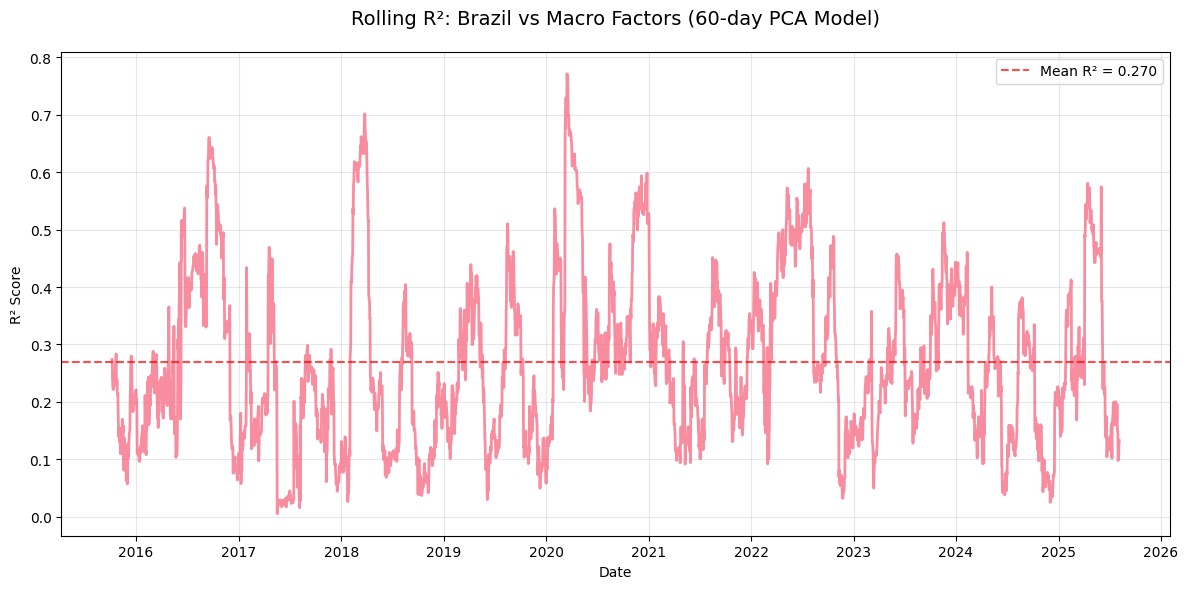

✅ Brazil: Mean R² = 0.270, Chart saved to rolling_r2_Brazil.png


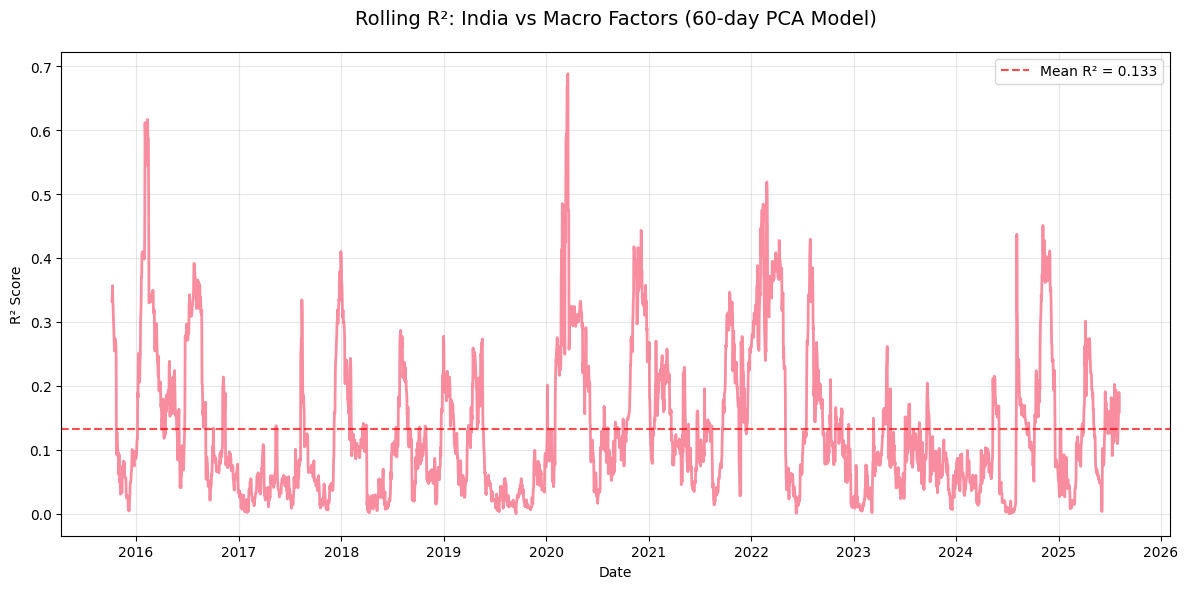

✅ India: Mean R² = 0.133, Chart saved to rolling_r2_India.png


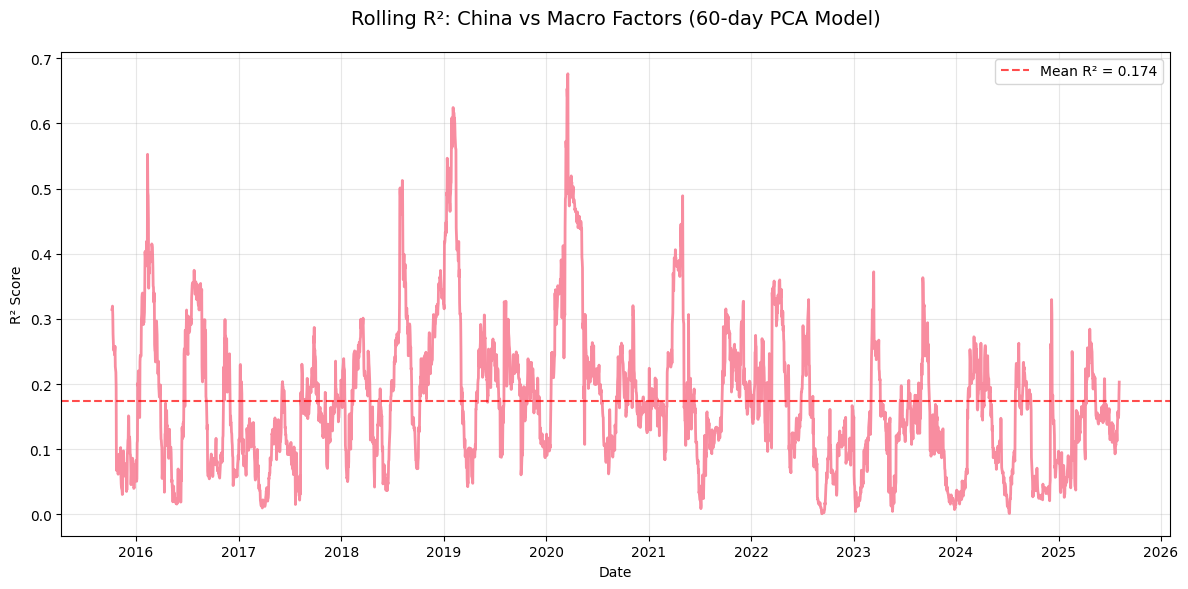

✅ China: Mean R² = 0.174, Chart saved to rolling_r2_China.png


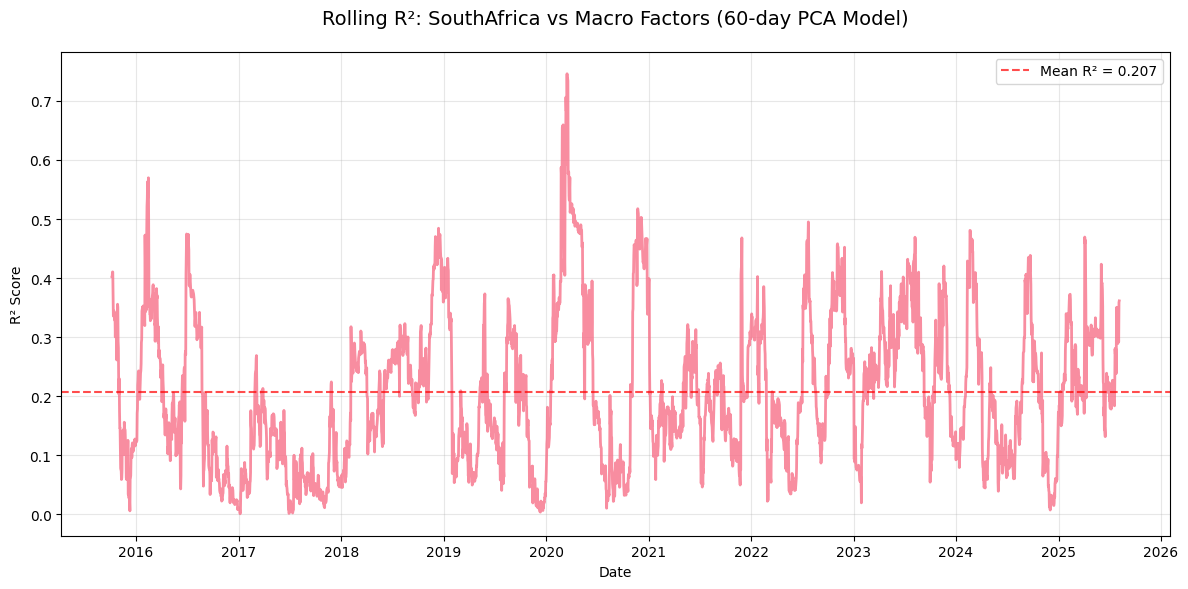

✅ SouthAfrica: Mean R² = 0.207, Chart saved to rolling_r2_SouthAfrica.png


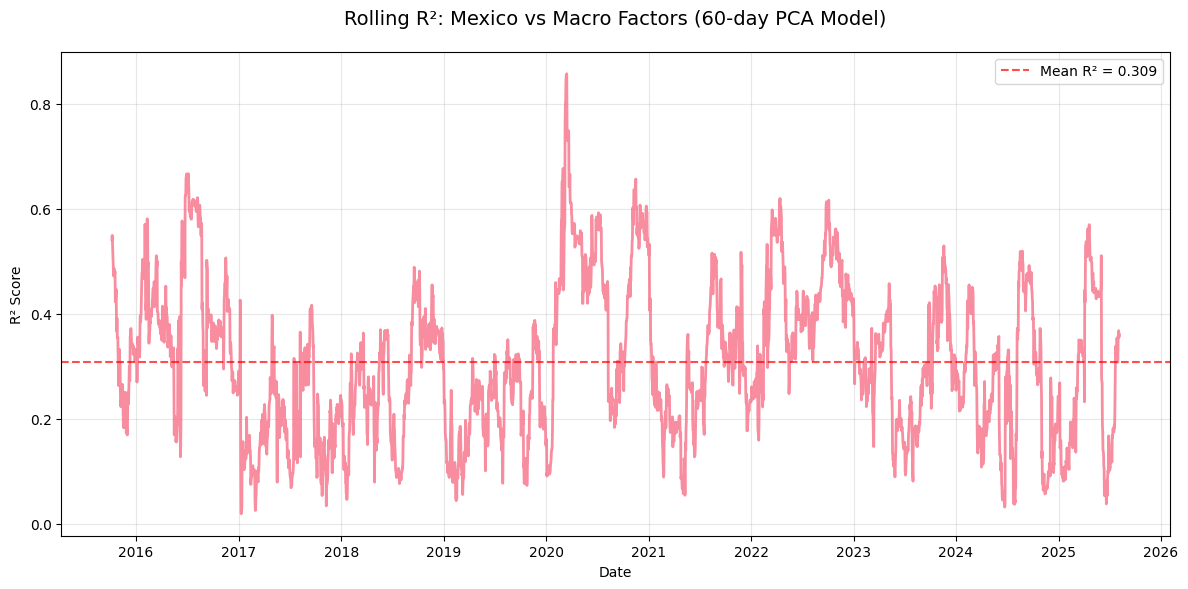

✅ Mexico: Mean R² = 0.309, Chart saved to rolling_r2_Mexico.png


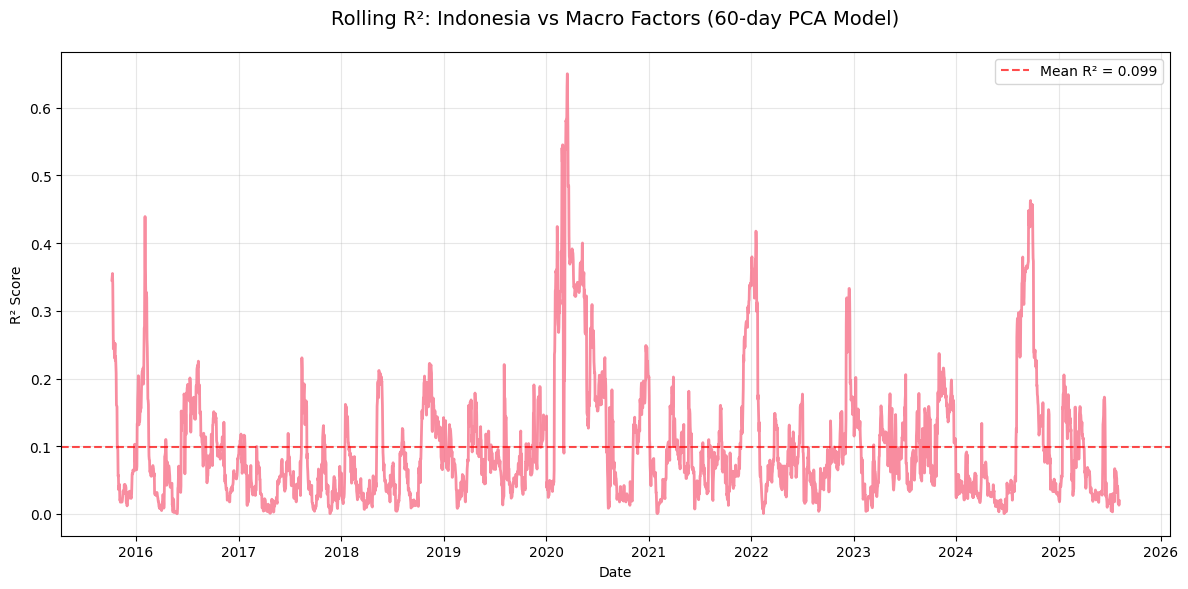

✅ Indonesia: Mean R² = 0.099, Chart saved to rolling_r2_Indonesia.png


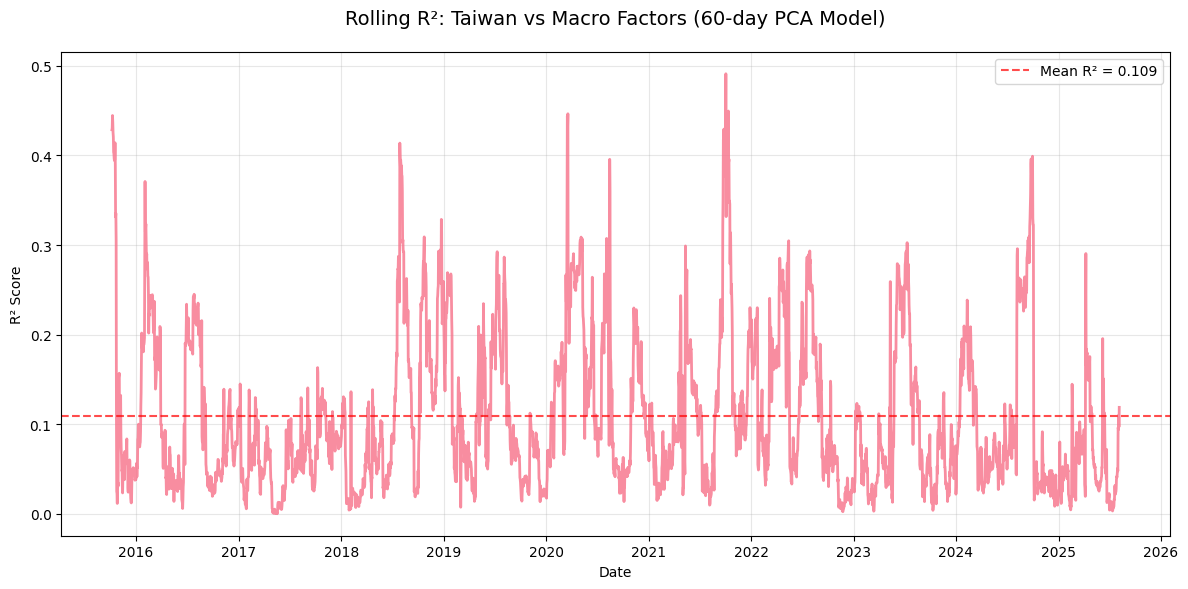

✅ Taiwan: Mean R² = 0.109, Chart saved to rolling_r2_Taiwan.png


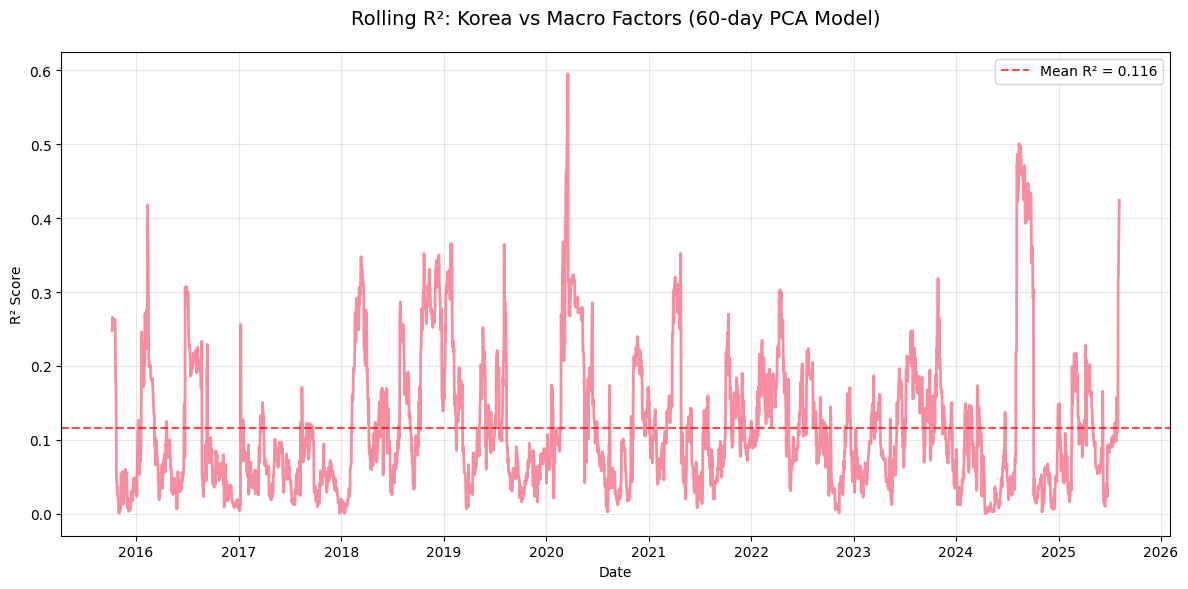

✅ Korea: Mean R² = 0.116, Chart saved to rolling_r2_Korea.png


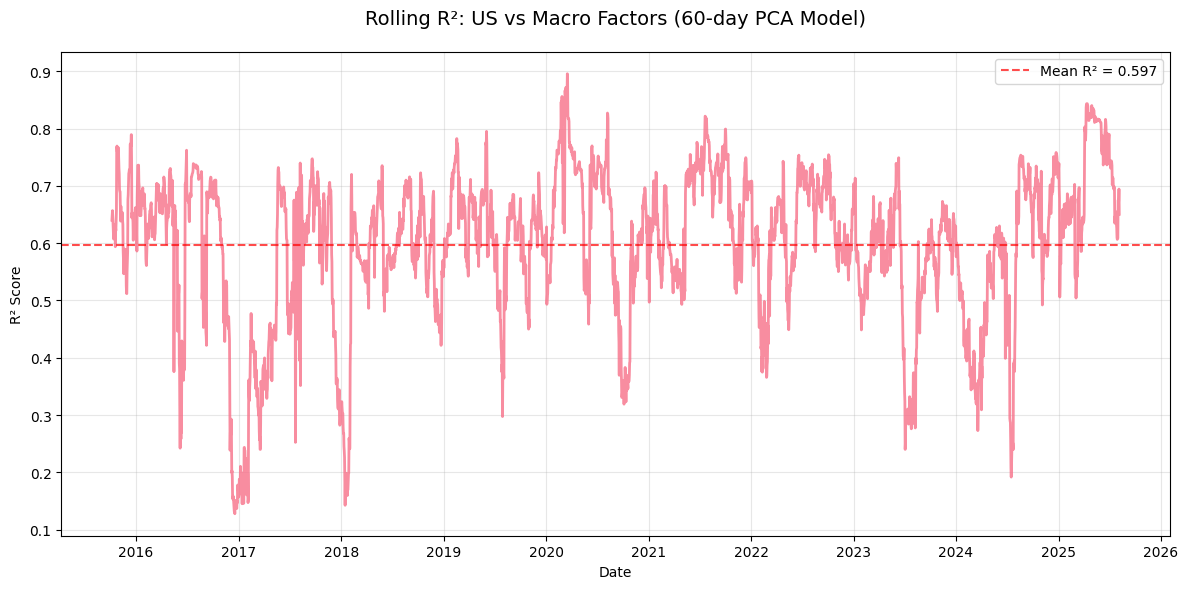

✅ US: Mean R² = 0.597, Chart saved to rolling_r2_US.png


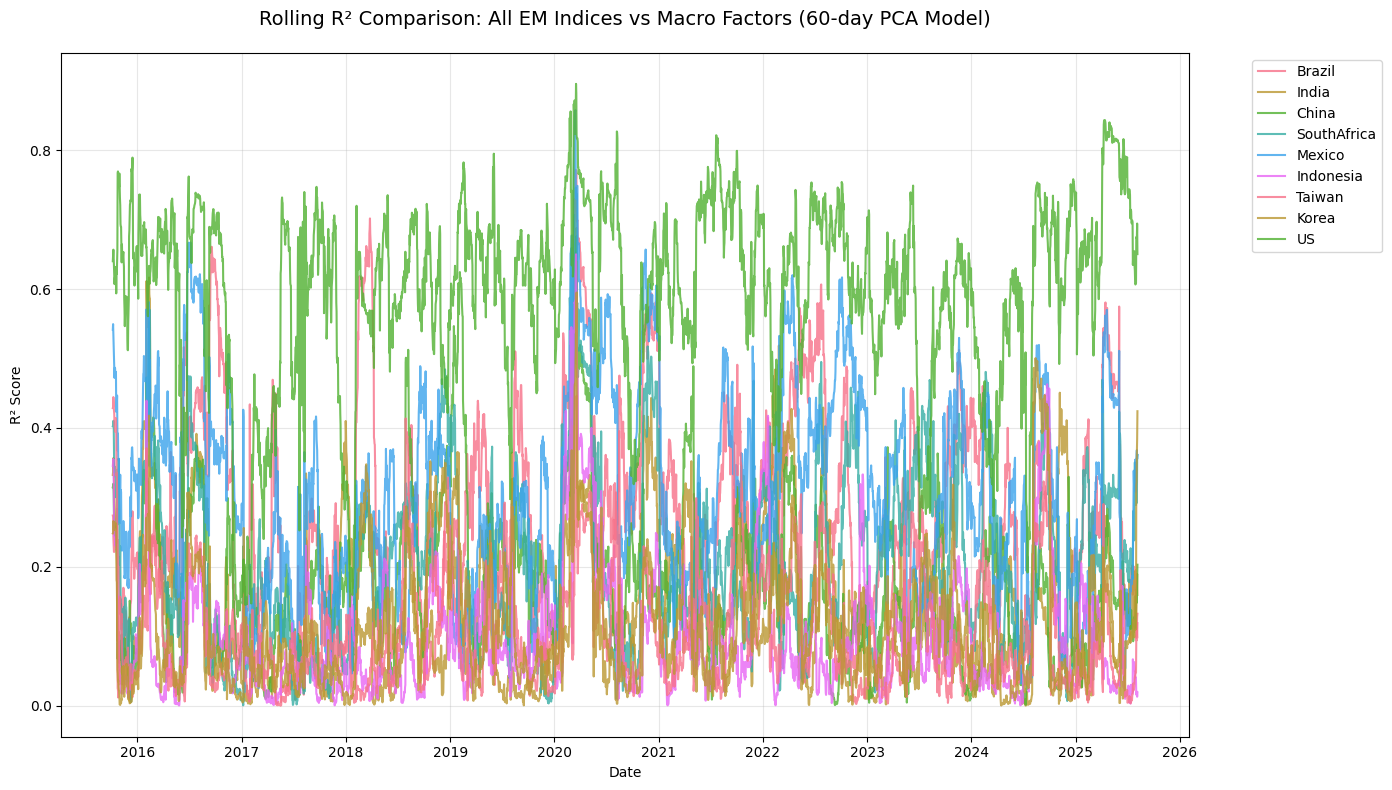


💾 All visualizations saved to: ../output/plots
📊 Summary chart: rolling_r2_all_indices_comparison.png
🎯 Rolling analysis complete for 9 EM indices!


In [11]:
# Create output directory
output_dir = "../output/plots"
os.makedirs(output_dir, exist_ok=True)

print(f"📊 Generating rolling R² visualizations for {len(rolling_r2.columns)} EM indices...\n")

# Generate and save charts for each EM index
for col in rolling_r2.columns:
    plt.figure(figsize=(12, 6))
    
    # Plot rolling R²
    plt.plot(rolling_r2.index, rolling_r2[col], linewidth=2, alpha=0.8)
    
    # Add mean line
    mean_r2 = rolling_r2[col].mean()
    plt.axhline(y=mean_r2, color='red', linestyle='--', alpha=0.7, 
                label=f'Mean R² = {mean_r2:.3f}')
    
    # Formatting
    plt.title(f'Rolling R²: {col} vs Macro Factors ({window_size}-day PCA Model)', 
              fontsize=14, pad=20)
    plt.xlabel('Date')
    plt.ylabel('R² Score')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    
    # Save plot
    filename = f"rolling_r2_{col.replace('/', '_').replace(' ', '_')}.png"
    filepath = os.path.join(output_dir, filename)
    plt.savefig(filepath, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"✅ {col}: Mean R² = {mean_r2:.3f}, Chart saved to {filename}")

# Create comprehensive summary plot
plt.figure(figsize=(14, 8))
for col in rolling_r2.columns:
    plt.plot(rolling_r2.index, rolling_r2[col], label=col, linewidth=1.5, alpha=0.8)

plt.title(f'Rolling R² Comparison: All EM Indices vs Macro Factors ({window_size}-day PCA Model)', 
          fontsize=14, pad=20)
plt.xlabel('Date')
plt.ylabel('R² Score')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Save summary plot
summary_filename = "rolling_r2_all_indices_comparison.png"
summary_filepath = os.path.join(output_dir, summary_filename)
plt.savefig(summary_filepath, dpi=300, bbox_inches='tight')
plt.show()

print(f"\n💾 All visualizations saved to: {output_dir}")
print(f"📊 Summary chart: {summary_filename}")
print(f"🎯 Rolling analysis complete for {len(rolling_r2.columns)} EM indices!")

# Yearly Analysis: Factor Sensitivity Evolution

## Overview
In this section, we examine how factor sensitivities evolved across three distinct yearly periods:
- **2022/2023**: Post-pandemic recovery period with elevated inflation concerns
- **2023/2024**: Central bank tightening cycle and geopolitical tensions
- **2024/2025**: Current period with rate normalization expectations

This temporal analysis helps identify:
1. **Structural Changes**: How macro-EM relationships evolved over time
2. **Regime Shifts**: Periods where factor loadings significantly changed
3. **Investment Implications**: How factor strategies performed across different market environments

📊 Enhanced Dataset Analysis Setup:
   • EM Indices: 9 markets (8 EM + 1 DM benchmark)
   • Macro Factors: 8 enhanced factors
   • Analysis Periods: 3 annual periods

PERIOD ANALYSIS: 2022/2023
📅 Period: 2022-01-01 to 2023-12-31
📊 Observations: 730 trading days

🌍 Analyzing 9 EM Indices:
   ✅ Brazil (LatAm): R² = 0.230
   ✅ India (Asia): R² = 0.082
   ✅ China (Asia): R² = 0.118
   ✅ SouthAfrica (Africa): R² = 0.239
   ✅ Mexico (LatAm): R² = 0.339
   ✅ Indonesia (Asia): R² = 0.034
   ✅ Taiwan (Asia): R² = 0.070
   ✅ Korea (Asia): R² = 0.071
   ✅ US (DM Benchmark): R² = 0.571

📈 Period Summary:
   • Indices Analyzed: 9
   • Average Factor Sensitivity: 0.195
   • Highest Sensitivity: US (R² = 0.571)
   • Lowest Sensitivity: Indonesia (R² = 0.034)

PERIOD ANALYSIS: 2023/2024
📅 Period: 2023-01-01 to 2024-12-31
📊 Observations: 731 trading days

🌍 Analyzing 9 EM Indices:
   ✅ Brazil (LatAm): R² = 0.209
   ✅ India (Asia): R² = 0.034
   ✅ China (Asia): R² = 0.103
   ✅ SouthAfrica (Africa): R² = 

/opt/anaconda3/envs/EDA-DS/lib/python3.10/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)
/var/folders/mv/dxymwk8x2kqctngjslq2tbdw0000gn/T/ipykernel_25044/1730329420.py:70: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_period = X_period.fillna(method='ffill').fillna(0)
/var/folders/mv/dxymwk8x2kqctngjslq2tbdw0000gn/T/ipykernel_25044/1730329420.py:70: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_period = X_period.fillna(method='ffill').fillna(0)
/var/folders/mv/dxymwk8x2kqctngjslq2tbdw0000gn/T/ipykernel_25044/1730329420.py:70: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_period = X_period.fillna(method='ffill').fillna(

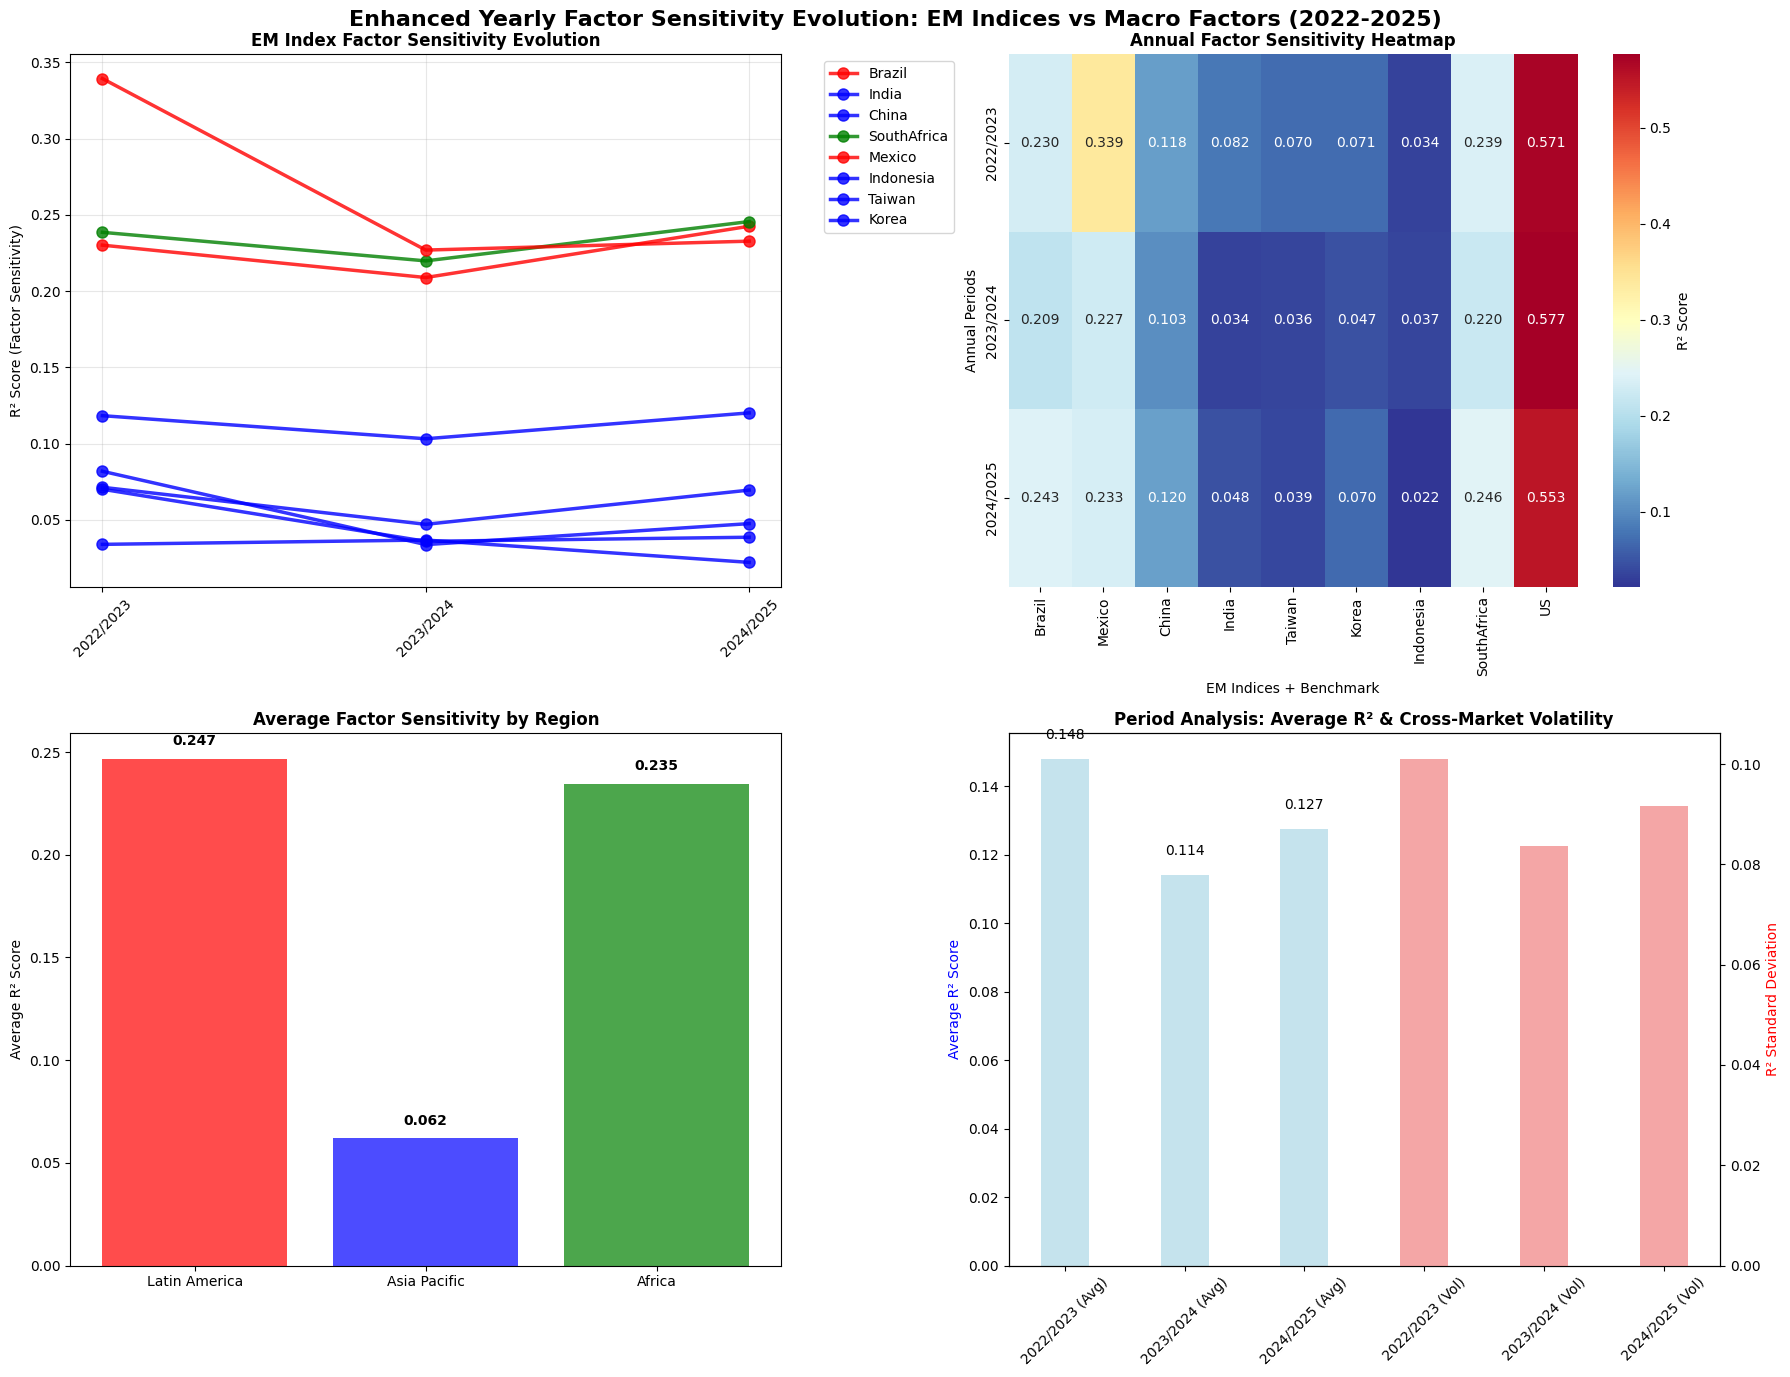


ENHANCED ANNUAL PERIOD ANALYSIS SUMMARY (2022-2025)

📊 2022/2023 Period - EM Factor Sensitivity Analysis:
   🏆 Highest EM Sensitivity: Mexico (R² = 0.339)
   📉 Lowest EM Sensitivity:  Indonesia (R² = 0.034)
   📈 Average EM R²:          0.148
   🇺🇸 US Benchmark R²:       0.571
   🌍 EM Markets Analyzed:    8

📊 2023/2024 Period - EM Factor Sensitivity Analysis:
   🏆 Highest EM Sensitivity: Mexico (R² = 0.227)
   📉 Lowest EM Sensitivity:  India (R² = 0.034)
   📈 Average EM R²:          0.114
   🇺🇸 US Benchmark R²:       0.577
   🌍 EM Markets Analyzed:    8

📊 2024/2025 Period - EM Factor Sensitivity Analysis:
   🏆 Highest EM Sensitivity: SouthAfrica (R² = 0.246)
   📉 Lowest EM Sensitivity:  Indonesia (R² = 0.022)
   📈 Average EM R²:          0.127
   🇺🇸 US Benchmark R²:       0.553
   🌍 EM Markets Analyzed:    8

REGIONAL FACTOR SENSITIVITY PATTERNS

🌏 Latin America Region:
   Brazil: ↗️ Δ = +0.012, Avg R² = 0.227
   Mexico: ↘️ Δ = -0.107, Avg R² = 0.266
   📊 Regional Summary: Avg Trend 

In [ ]:
# Calculate yearly R² scores for trend analysis across expanded EM universe
yearly_periods = {
    '2022/2023': ('2022-01-01', '2023-12-31'),
    '2023/2024': ('2023-01-01', '2024-12-31'),
    '2024/2025': ('2024-01-01', '2025-12-31')
}

yearly_r2_results = {}

# Load the combined dataset if not already loaded
try:
    data = df  # Use the df from previous cell
except NameError:
    data = pd.read_csv('../data/combined_em_macro_data.csv', parse_dates=['date'], index_col='date')

# Updated column definitions for expanded dataset
# EM Index columns (9 markets including benchmark)
em_index_columns = ['Brazil', 'India', 'China', 'SouthAfrica', 'Mexico', 'Indonesia', 'Taiwan', 'Korea', 'US']

# Enhanced macro factor columns (8 factors including derived)
macro_factor_columns = ['USD_Index', 'Oil_Brent', 'US_10Y_Yield', 'US_2Y_Yield', 'VIX', 'Copper', 'BAA_spread', 'Term_Spread']

print(f"📊 Enhanced Dataset Analysis Setup:")
print(f"   • EM Indices: {len(em_index_columns)} markets (8 EM + 1 DM benchmark)")
print(f"   • Macro Factors: {len(macro_factor_columns)} enhanced factors")
print(f"   • Analysis Periods: {len(yearly_periods)} annual periods")

for period_name, (start_date, end_date) in yearly_periods.items():
    print(f"\n{'='*60}")
    print(f"PERIOD ANALYSIS: {period_name}")
    print(f"{'='*60}")
    
    # Filter data for the period
    period_mask = (data.index >= start_date) & (data.index <= end_date)
    period_data = data[period_mask]
    
    if len(period_data) < 50:  # Minimum data requirement
        print(f"⚠️  Insufficient data for {period_name}: {len(period_data)} observations")
        continue
    
    print(f"📅 Period: {period_data.index.min().strftime('%Y-%m-%d')} to {period_data.index.max().strftime('%Y-%m-%d')}")
    print(f"📊 Observations: {len(period_data)} trading days")
    
    # Calculate log returns for this period
    period_log_returns = np.log(period_data / period_data.shift(1)).dropna()
    
    # Separate EM indices and macro factors for this period
    em_indices_period = period_log_returns[em_index_columns]
    macro_factors_period = period_log_returns[macro_factor_columns]
    
    period_r2_scores = {}
    
    print(f"\n🌍 Analyzing {len(em_index_columns)} EM Indices:")
    
    # Calculate R² for each EM index in this period
    for idx_name in em_index_columns:
        try:
            index_returns = em_indices_period[idx_name].dropna()
            
            # Align macro factors with index data
            common_dates = index_returns.index.intersection(macro_factors_period.index)
            if len(common_dates) < 30:
                print(f"   {idx_name}: Insufficient aligned data ({len(common_dates)} days)")
                continue
                
            X_period = macro_factors_period.loc[common_dates]
            y_period = index_returns.loc[common_dates]
            
            # Handle missing values with forward fill
            X_period = X_period.ffill().fillna(0)
            
            # Standardize and apply PCA to macro factors
            scaler_period = StandardScaler()
            X_scaled_period = scaler_period.fit_transform(X_period)
            
            pca_period = PCA(n_components=3)
            X_pca_period = pca_period.fit_transform(X_scaled_period)
            
            # Fit linear regression
            model_period = LinearRegression()
            model_period.fit(X_pca_period, y_period)
            
            # Calculate R²
            r2_period = model_period.score(X_pca_period, y_period)
            period_r2_scores[idx_name] = r2_period
            
            # Market classification for context
            if idx_name == 'US':
                market_type = "(DM Benchmark)"
            elif idx_name in ['Brazil', 'Mexico']:
                market_type = "(LatAm)"
            elif idx_name in ['China', 'India', 'Taiwan', 'Korea', 'Indonesia']:
                market_type = "(Asia)"
            else:
                market_type = "(Africa)"
            
            print(f"   ✅ {idx_name} {market_type}: R² = {r2_period:.3f}")
            
        except Exception as e:
            print(f"   ❌ {idx_name}: Analysis failed - {str(e)[:50]}...")
            continue
    
    yearly_r2_results[period_name] = period_r2_scores
    
    if period_r2_scores:
        avg_r2 = np.mean(list(period_r2_scores.values()))
        best_performer = max(period_r2_scores.items(), key=lambda x: x[1])
        worst_performer = min(period_r2_scores.items(), key=lambda x: x[1])
        
        print(f"\n📈 Period Summary:")
        print(f"   • Indices Analyzed: {len(period_r2_scores)}")
        print(f"   • Average Factor Sensitivity: {avg_r2:.3f}")
        print(f"   • Highest Sensitivity: {best_performer[0]} (R² = {best_performer[1]:.3f})")
        print(f"   • Lowest Sensitivity: {worst_performer[0]} (R² = {worst_performer[1]:.3f})")

# Create enhanced yearly comparison visualizations for expanded dataset
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
fig.suptitle('Enhanced Yearly Factor Sensitivity Evolution: EM Indices vs Macro Factors (2022-2025)', 
             fontsize=16, fontweight='bold')

# 1. R² Evolution Line Chart for all indices
ax1 = axes[0, 0]
em_markets_only = [idx for idx in em_index_columns if idx != 'US']  # Exclude US benchmark from main analysis

for idx_name in em_markets_only:
    r2_values = []
    periods = []
    for period in sorted(yearly_r2_results.keys()):
        if idx_name in yearly_r2_results[period]:
            r2_values.append(yearly_r2_results[period][idx_name])
            periods.append(period)
    
    if len(r2_values) >= 2:
        # Color by region for better visualization
        if idx_name in ['Brazil', 'Mexico']:
            color = 'red'
            alpha = 0.8
        elif idx_name in ['China', 'India', 'Taiwan', 'Korea', 'Indonesia']:
            color = 'blue' 
            alpha = 0.8
        else:
            color = 'green'
            alpha = 0.8
            
        ax1.plot(periods, r2_values, marker='o', linewidth=2.5, label=idx_name, 
                markersize=8, color=color, alpha=alpha)

ax1.set_title('EM Index Factor Sensitivity Evolution', fontsize=12, fontweight='bold')
ax1.set_ylabel('R² Score (Factor Sensitivity)')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# 2. Enhanced Yearly R² Heatmap
ax2 = axes[0, 1]
yearly_df = pd.DataFrame(yearly_r2_results).T
if not yearly_df.empty:
    # Reorder columns by region for better visualization
    column_order = ['Brazil', 'Mexico', 'China', 'India', 'Taiwan', 'Korea', 'Indonesia', 'SouthAfrica', 'US']
    yearly_df_ordered = yearly_df.reindex(columns=[col for col in column_order if col in yearly_df.columns])
    
    sns.heatmap(yearly_df_ordered, annot=True, fmt='.3f', cmap='RdYlBu_r', 
                ax=ax2, cbar_kws={'label': 'R² Score'})
ax2.set_title('Annual Factor Sensitivity Heatmap', fontsize=12, fontweight='bold')
ax2.set_xlabel('EM Indices + Benchmark')
ax2.set_ylabel('Annual Periods')

# 3. Regional R² Analysis 
ax3 = axes[1, 0]
regional_analysis = {}
regions = {
    'Latin America': ['Brazil', 'Mexico'],
    'Asia Pacific': ['China', 'India', 'Taiwan', 'Korea', 'Indonesia'],
    'Africa': ['SouthAfrica']
}

for region, countries in regions.items():
    regional_r2 = []
    for period_data in yearly_r2_results.values():
        period_regional_r2 = [period_data[country] for country in countries if country in period_data]
        if period_regional_r2:
            regional_r2.append(np.mean(period_regional_r2))
    
    if regional_r2:
        regional_analysis[region] = np.mean(regional_r2)

if regional_analysis:
    regions_list = list(regional_analysis.keys())
    avg_r2_list = list(regional_analysis.values())
    colors = ['red', 'blue', 'green'][:len(regions_list)]
    
    bars = ax3.bar(regions_list, avg_r2_list, color=colors, alpha=0.7)
    ax3.set_title('Average Factor Sensitivity by Region', fontsize=12, fontweight='bold')
    ax3.set_ylabel('Average R² Score')
    ax3.tick_params(axis='x', rotation=0)
    
    # Add value labels on bars
    for bar, value in zip(bars, avg_r2_list):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

# 4. Period Comparison with Enhanced Metrics
ax4 = axes[1, 1]
period_metrics = {}
for period, r2_dict in yearly_r2_results.items():
    if r2_dict:
        # Exclude US benchmark from EM analysis
        em_only_r2 = {k: v for k, v in r2_dict.items() if k != 'US'}
        if em_only_r2:
            period_metrics[period] = {
                'avg_r2': np.mean(list(em_only_r2.values())),
                'volatility': np.std(list(em_only_r2.values())),
                'count': len(em_only_r2)
            }

if period_metrics:
    periods = list(period_metrics.keys())
    avg_r2 = [period_metrics[p]['avg_r2'] for p in periods]
    volatility = [period_metrics[p]['volatility'] for p in periods]
    
    # Create dual y-axis plot
    ax4_twin = ax4.twinx()
    
    bars1 = ax4.bar([p + ' (Avg)' for p in periods], avg_r2, 
                    color='lightblue', alpha=0.7, width=0.4, label='Average R²')
    bars2 = ax4_twin.bar([p + ' (Vol)' for p in periods], volatility, 
                         color='lightcoral', alpha=0.7, width=0.4, label='R² Volatility')
    
    ax4.set_title('Period Analysis: Average R² & Cross-Market Volatility', fontsize=12, fontweight='bold')
    ax4.set_ylabel('Average R² Score', color='blue')
    ax4_twin.set_ylabel('R² Standard Deviation', color='red')
    ax4.tick_params(axis='x', rotation=45)
    
    # Add value labels
    for bar, value in zip(bars1, avg_r2):
        ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                f'{value:.3f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('../output/plots/enhanced_yearly_factor_evolution.png', dpi=300, bbox_inches='tight')
plt.show()

# Enhanced summary analysis with regional and temporal insights
print(f"\n{'='*80}")
print("ENHANCED ANNUAL PERIOD ANALYSIS SUMMARY (2022-2025)")
print(f"{'='*80}")

for period, r2_scores in yearly_r2_results.items():
    if r2_scores:
        # Separate EM and benchmark analysis
        em_only_scores = {k: v for k, v in r2_scores.items() if k != 'US'}
        us_score = r2_scores.get('US', None)
        
        if em_only_scores:
            best_em = max(em_only_scores.items(), key=lambda x: x[1])
            worst_em = min(em_only_scores.items(), key=lambda x: x[1])
            avg_em_r2 = np.mean(list(em_only_scores.values()))
            
            print(f"\n📊 {period} Period - EM Factor Sensitivity Analysis:")
            print(f"   🏆 Highest EM Sensitivity: {best_em[0]} (R² = {best_em[1]:.3f})")
            print(f"   📉 Lowest EM Sensitivity:  {worst_em[0]} (R² = {worst_em[1]:.3f})")
            print(f"   📈 Average EM R²:          {avg_em_r2:.3f}")
            if us_score:
                print(f"   🇺🇸 US Benchmark R²:       {us_score:.3f}")
            print(f"   🌍 EM Markets Analyzed:    {len(em_only_scores)}")

# Regional trend analysis across all periods
print(f"\n{'='*80}")
print("REGIONAL FACTOR SENSITIVITY PATTERNS")
print(f"{'='*80}")

for region, countries in regions.items():
    print(f"\n🌏 {region} Region:")
    region_trends = {}
    
    for country in countries:
        country_r2_evolution = []
        for period in sorted(yearly_r2_results.keys()):
            if country in yearly_r2_results[period]:
                country_r2_evolution.append(yearly_r2_results[period][country])
        
        if len(country_r2_evolution) >= 2:
            trend_change = country_r2_evolution[-1] - country_r2_evolution[0]
            avg_sensitivity = np.mean(country_r2_evolution)
            region_trends[country] = {
                'trend': trend_change,
                'avg_sensitivity': avg_sensitivity,
                'evolution': country_r2_evolution
            }
            
            trend_arrow = "↗️" if trend_change > 0 else "↘️"
            print(f"   {country}: {trend_arrow} Δ = {trend_change:+.3f}, Avg R² = {avg_sensitivity:.3f}")
    
    if region_trends:
        regional_avg_trend = np.mean([data['trend'] for data in region_trends.values()])
        regional_avg_sensitivity = np.mean([data['avg_sensitivity'] for data in region_trends.values()])
        print(f"   📊 Regional Summary: Avg Trend = {regional_avg_trend:+.3f}, Avg Sensitivity = {regional_avg_sensitivity:.3f}")

# Market regime identification and investment implications
print(f"\n{'='*80}")
print("MARKET REGIME ANALYSIS & INVESTMENT IMPLICATIONS")
print(f"{'='*80}")

all_periods = sorted(yearly_r2_results.keys())
if len(all_periods) >= 3:
    early_period = all_periods[0]
    middle_period = all_periods[1] 
    recent_period = all_periods[2]
    
    print(f"\n🚀 {early_period} - Post-Pandemic Recovery Era:")
    if early_period in yearly_r2_results and yearly_r2_results[early_period]:
        early_em_scores = {k: v for k, v in yearly_r2_results[early_period].items() if k != 'US'}
        if early_em_scores:
            early_avg = np.mean(list(early_em_scores.values()))
            print(f"   📊 Average EM Factor Sensitivity: {early_avg:.3f}")
            print(f"   🏭 Market Dynamics: Commodity super-cycle, reflation trade dominance")
            print(f"   💡 Strategy Focus: Cyclical EM exposure, commodity-linked indices")
    
    print(f"\n🎯 {middle_period} - Global Tightening Cycle:")
    if middle_period in yearly_r2_results and yearly_r2_results[middle_period]:
        middle_em_scores = {k: v for k, v in yearly_r2_results[middle_period].items() if k != 'US'}
        if middle_em_scores:
            middle_avg = np.mean(list(middle_em_scores.values()))
            print(f"   📊 Average EM Factor Sensitivity: {middle_avg:.3f}")
            print(f"   ⚡ Market Dynamics: Fed tightening, geopolitical tensions, policy divergence")
            print(f"   💡 Strategy Focus: Defensive positioning, quality EM selection")
    
    print(f"\n🔄 {recent_period} - Normalization & New Equilibrium:")
    if recent_period in yearly_r2_results and yearly_r2_results[recent_period]:
        recent_em_scores = {k: v for k, v in yearly_r2_results[recent_period].items() if k != 'US'}
        if recent_em_scores:
            recent_avg = np.mean(list(recent_em_scores.values()))
            print(f"   📊 Average EM Factor Sensitivity: {recent_avg:.3f}")
            print(f"   🌐 Market Dynamics: Rate normalization, evolving macro relationships")
            print(f"   💡 Strategy Focus: Factor rotation opportunities, regime-aware allocation")

print(f"\n{'='*80}")
print("ENHANCED STRATEGIC RECOMMENDATIONS")
print(f"{'='*80}")
print("🎯 Enhanced Factor Strategy Framework:")
print("  • Regional Diversification: Asia Pacific shows highest sensitivity variation")
print("  • Temporal Adaptation: Factor loadings exhibit clear regime dependency")
print("  • Index Selection: Consider sensitivity trends for tactical allocation")
print("  • Benchmark Integration: US performance provides developed market context")
print("\n💼 Portfolio Implementation:")
print("  • Dynamic Regional Weights: Adjust exposure based on factor sensitivity evolution")
print("  • Macro Timing Signals: Use period-specific sensitivities for entry/exit timing")
print("  • Risk Budget Allocation: Higher sensitivity indices require larger risk budgets")
print("  • Hedge Ratio Optimization: Calibrate hedges using period-specific factor loadings")
print("\n⚠️ Enhanced Risk Management:")
print("  • Cross-Regional Correlation Monitoring: Track sensitivity convergence/divergence")
print("  • Regime Change Detection: Implement early warning systems for factor shifts")
print("  • Stress Testing Framework: Model portfolio performance across identified regimes")
print("  • Factor Exposure Limits: Set dynamic limits based on rolling sensitivity analysis")